### NYC Taxi dataset:
Use NYC's openly available taxi-fare dataset to predict the price of a Taxi ride. Our goal is to use TF as the ML Framework to build a pipeline which should be capable of scaling on infinite data to make an enterprise scale model.

#Boilerplate setup

In [1]:
# Owner - Hasan Rafiq
# Load the TensorBoard notebook extension
%load_ext tensorboard

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

2.4.1
INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


In [2]:
!wget https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv

--2021-04-26 05:19:09--  https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1922812 (1.8M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.83M  --.-KB/s    in 0.1s    

2021-04-26 05:19:10 (17.4 MB/s) - ‘data.csv’ saved [1922812/1922812]



#Referral Data with 15K records

In [3]:
df = pd.read_csv('/content/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pickup_community_area   15000 non-null  float64
 1   fare                    15002 non-null  float64
 2   trip_start_month        15002 non-null  int64  
 3   trip_start_hour         15002 non-null  int64  
 4   trip_start_day          15002 non-null  int64  
 5   trip_start_timestamp    15002 non-null  int64  
 6   pickup_latitude         15000 non-null  float64
 7   pickup_longitude        15000 non-null  float64
 8   dropoff_latitude        14519 non-null  float64
 9   dropoff_longitude       14519 non-null  float64
 10  trip_miles              15002 non-null  float64
 11  pickup_census_tract     1 non-null      float64
 12  dropoff_census_tract    10761 non-null  float64
 13  payment_type            15002 non-null  object 
 14  company                 9862 non-null 

#Referral Data preprocessing

In [4]:
df.head()

pickup_community_area   fare  ...  dropoff_community_area  tips
0                    NaN  12.45  ...                     NaN   0.0
1                    NaN   0.00  ...                     NaN   0.0
2                   60.0  27.05  ...                     NaN   0.0
3                   10.0   5.85  ...                     NaN   0.0
4                   14.0  16.65  ...                     NaN   0.0

[5 rows x 18 columns]

In [5]:
df.nunique()

pickup_community_area        62
fare                        423
trip_start_month             12
trip_start_hour              24
trip_start_day                7
trip_start_timestamp      13789
pickup_latitude             236
pickup_longitude            236
dropoff_latitude            291
dropoff_longitude           291
trip_miles                  530
pickup_census_tract           1
dropoff_census_tract        229
payment_type                  7
company                      61
trip_seconds                110
dropoff_community_area       69
tips                        462
dtype: int64

In [6]:
df.describe()

pickup_community_area  ...          tips
count           15000.000000  ...  15002.000000
mean               22.250267  ...      1.076674
std                19.414828  ...      2.158340
min                 1.000000  ...      0.000000
25%                 8.000000  ...      0.000000
50%                 8.000000  ...      0.000000
75%                32.000000  ...      2.000000
max                77.000000  ...     47.000000

[8 rows x 16 columns]

In [7]:

df = df.drop(['trip_start_timestamp','pickup_census_tract',
              'dropoff_census_tract','trip_seconds','payment_type','tips','dropoff_community_area','pickup_community_area'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15002 entries, 0 to 15001
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare               15002 non-null  float64
 1   trip_start_month   15002 non-null  int64  
 2   trip_start_hour    15002 non-null  int64  
 3   trip_start_day     15002 non-null  int64  
 4   pickup_latitude    15000 non-null  float64
 5   pickup_longitude   15000 non-null  float64
 6   dropoff_latitude   14519 non-null  float64
 7   dropoff_longitude  14519 non-null  float64
 8   trip_miles         15002 non-null  float64
 9   company            9862 non-null   object 
dtypes: float64(6), int64(3), object(1)
memory usage: 1.1+ MB


# Kaggle NYC Dataset


In [8]:

# load some default Python modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
ls -lrt

total 1888
drwxr-xr-x 1 root root    4096 Apr 21 13:39 sample_data/
-rw-r--r-- 1 root root 1922812 Apr 26 05:19 data.csv
drwx------ 6 root root    4096 Apr 26 05:19 drive/


In [11]:
train = pd.read_csv('/content/drive/My Drive/DeepLearning/TaxiDataset/train.csv', sep=',',nrows=150000)
train.head()

key  ...  passenger_count
0    2009-06-15 17:26:21.0000001  ...                1
1    2010-01-05 16:52:16.0000002  ...                1
2   2011-08-18 00:35:00.00000049  ...                2
3    2012-04-21 04:30:42.0000001  ...                1
4  2010-03-09 07:51:00.000000135  ...                1

[5 rows x 8 columns]

In [12]:
print(train.describe())
print("old size: %d" % len(train))
train = train[train.fare_amount >=0]
print("New size: %d" % len(train))
# check missing data
print(train.isnull().sum())

         fare_amount  pickup_longitude  ...  dropoff_latitude  passenger_count
count  150000.000000     150000.000000  ...     149999.000000    150000.000000
mean       11.361849        -72.500714  ...         39.928809         1.680407
std         9.870671         10.586363  ...          6.110042         1.305797
min       -44.900000       -736.550000  ...        -74.015160         0.000000
25%         6.000000        -73.992028  ...         40.734126         1.000000
50%         8.500000        -73.981732  ...         40.753243         1.000000
75%        12.500000        -73.966989  ...         40.768088         2.000000
max       500.000000         40.787575  ...        404.616667         6.000000

[8 rows x 6 columns]
old size: 150000
New size: 149990
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


# Time features
This was not a part of the collab shared

In [13]:
def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df['trip_start_hour'] = df.pickup_datetime.dt.hour
  

    df['trip_start_month'] = df.pickup_datetime.dt.month
    df["trip_start_day"] = df.pickup_datetime.dt.weekday

    
    return df

In [14]:
train = prepare_time_features(train)

In [15]:
##Drop useless columns
train = train.drop(['pickup_datetime','passenger_count','key'], axis=1)

In [16]:

train.info()
train = train[['fare_amount' ,'trip_start_month' ,'trip_start_hour' ,'trip_start_day' ,'pickup_latitude' ,'pickup_longitude' , 'dropoff_latitude' , 'dropoff_longitude']]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149990 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        149990 non-null  float64
 1   pickup_longitude   149990 non-null  float64
 2   pickup_latitude    149990 non-null  float64
 3   dropoff_longitude  149989 non-null  float64
 4   dropoff_latitude   149989 non-null  float64
 5   trip_start_hour    149990 non-null  int64  
 6   trip_start_month   149990 non-null  int64  
 7   trip_start_day     149990 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 10.3 MB


# Retaining the structure of referral dataset


In [17]:
train = train.rename(columns={"fare_amount": "fare" ,'trip_start_month':'trip_start_month','trip_start_hour':'trip_start_hour','trip_start_day':'trip_start_day','pickup_latitude':'pickup_latitude','pickup_longitude' :'pickup_longitude' ,'dropoff_latitude' :'dropoff_latitude','dropoff_longitude':'dropoff_longitude'})
train.info()
df=train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149990 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               149990 non-null  float64
 1   trip_start_month   149990 non-null  int64  
 2   trip_start_hour    149990 non-null  int64  
 3   trip_start_day     149990 non-null  int64  
 4   pickup_latitude    149990 non-null  float64
 5   pickup_longitude   149990 non-null  float64
 6   dropoff_latitude   149989 non-null  float64
 7   dropoff_longitude  149989 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 10.3 MB


In [18]:
#Drop NA rows
df = df.dropna()

#Drop rows where FARE > 200( only 1 row found )
df = df.drop(df[df['fare'] > 200].index)
#jsgruti
#df = df.drop(["company"],axis=1)
#
#Change datatype of cols
df['trip_start_month'] = df['trip_start_month'].astype('str')
df['trip_start_hour'] = df['trip_start_hour'].astype('str')
df['trip_start_day'] = df['trip_start_day'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149984 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               149984 non-null  float64
 1   trip_start_month   149984 non-null  object 
 2   trip_start_hour    149984 non-null  object 
 3   trip_start_day     149984 non-null  object 
 4   pickup_latitude    149984 non-null  float64
 5   pickup_longitude   149984 non-null  float64
 6   dropoff_latitude   149984 non-null  float64
 7   dropoff_longitude  149984 non-null  float64
dtypes: float64(5), object(3)
memory usage: 10.3+ MB


In [19]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

127469
22515


In [20]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)

127469
22515


#Exploratory Data Analysis

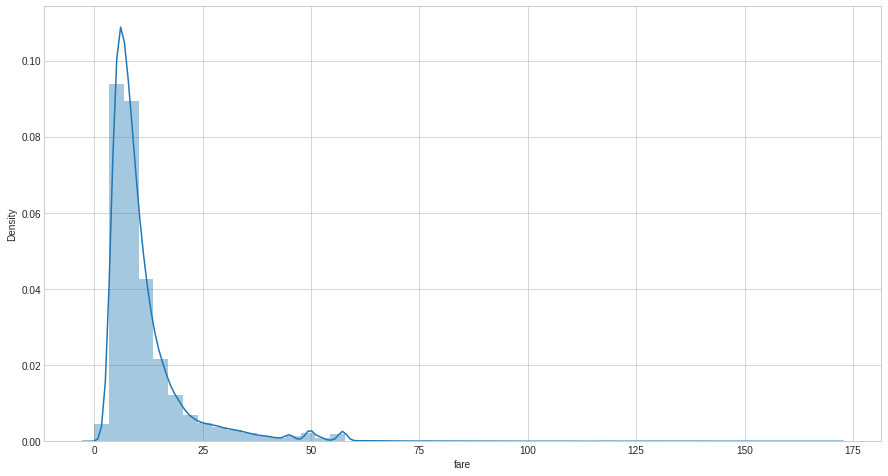

In [21]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare'])

In [22]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude'], traindf['pickup_longitude'], traindf['fare']), radius = 10))
m.fit_bounds([sw, ne])
m

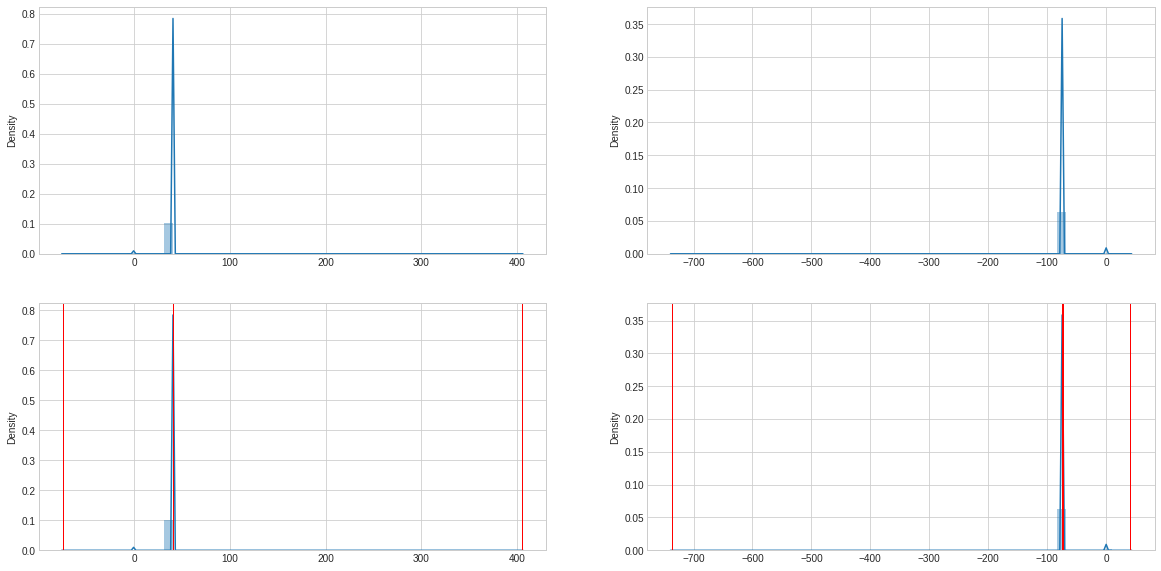

In [23]:
##Quantile Bucketization of latitude and longitude
# bins_lat = np.linspace(np.min([np.min(df['dropoff_latitude']),np.min(df['pickup_latitude'])]),
#             np.max([np.max(df['dropoff_latitude']),np.max(df['pickup_latitude'])]),
#             20)
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]

# bins_lon = np.linspace(np.min([np.min(df['dropoff_longitude']),np.min(df['pickup_longitude'])]),
#             np.max([np.max(df['dropoff_longitude']),np.max(df['pickup_longitude'])]),
#             20)
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

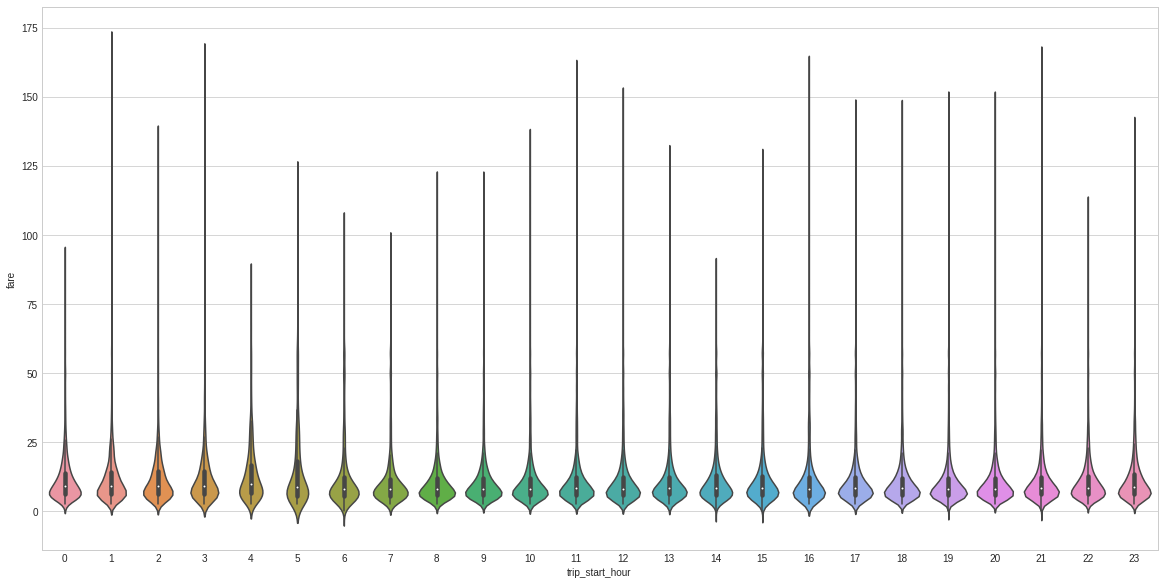

In [24]:

plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

#Box plot for Trip_start_hour

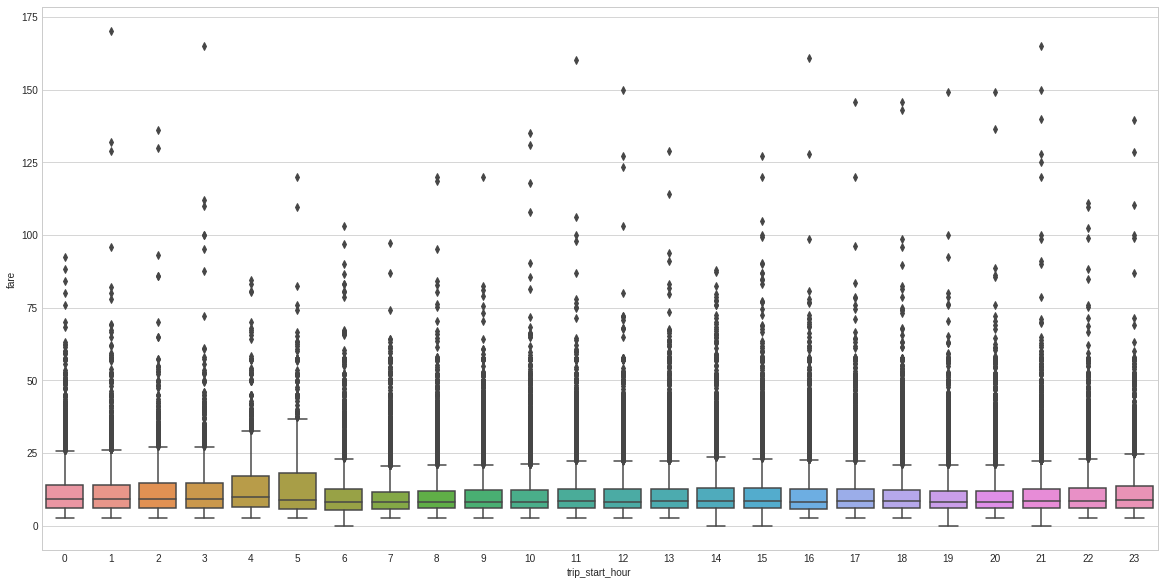

In [25]:

plt.figure(figsize=(20, 10))
sns.boxplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare'])

# Distribution of Trip_start_day

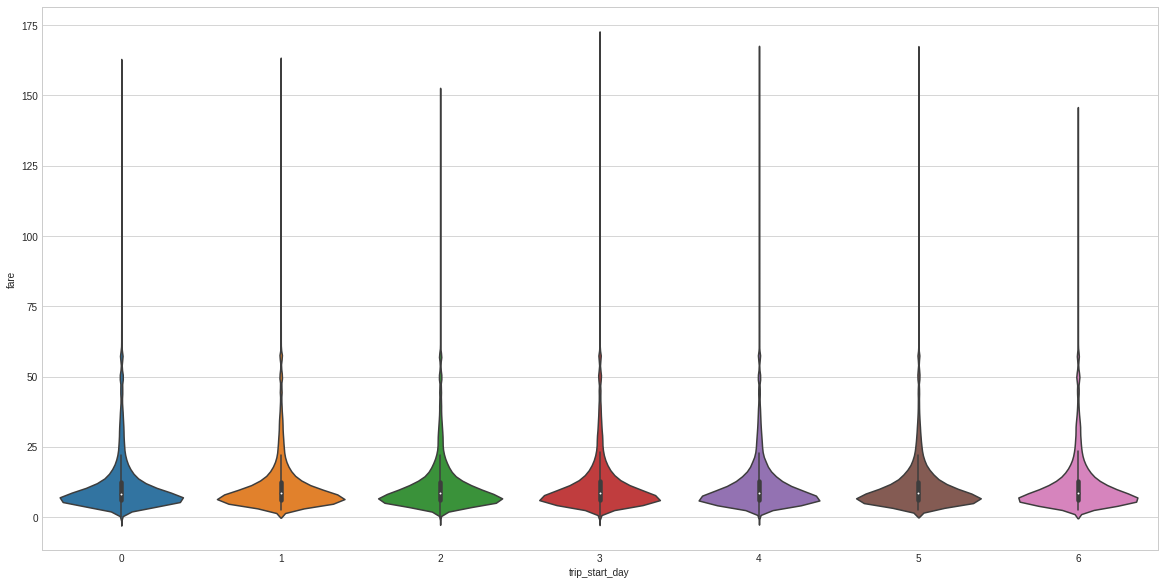

In [26]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare'])

# Different view of trip_start_hour distribution

Text(0.5, 1.0, 'Histogram of start hour')

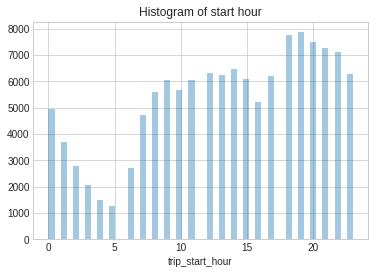

In [27]:

sns.distplot(traindf['trip_start_hour'].astype(int), kde =False).set_title("Histogram of start hour")


In [28]:
traindf

fare trip_start_month  ... dropoff_latitude dropoff_longitude
0        4.50                6  ...        40.712278        -73.841610
1       16.90                1  ...        40.782004        -73.979268
2        5.70                8  ...        40.750562        -73.991242
3        7.70                4  ...        40.758092        -73.991567
4        5.30                3  ...        40.783762        -73.956655
...       ...              ...  ...              ...               ...
149994   6.10                1  ...        40.743147        -73.904303
149995  49.57               10  ...        40.643617        -73.790216
149996  22.00                9  ...        40.684642        -73.956377
149997   4.50                9  ...        40.763693        -73.970902
149999  16.00               12  ...        40.765731        -73.982975

[127469 rows x 8 columns]

# Target label distribution

Text(0.5, 1.0, 'Histogram of fare price')

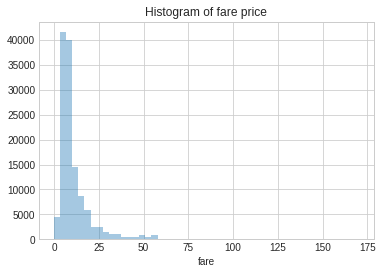

In [29]:

sns.distplot(traindf['fare'].astype(int), kde =False).set_title("Histogram of fare price")


New-added data visualization

Text(0.5, 1.0, 'Histogram of trip distrubution on start days')

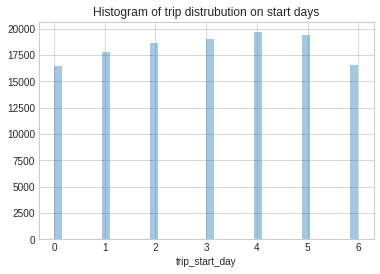

In [30]:


sns.distplot(traindf['trip_start_day'].astype(int), kde =False).set_title("Histogram of trip distrubution on start days")


New-added data visualization

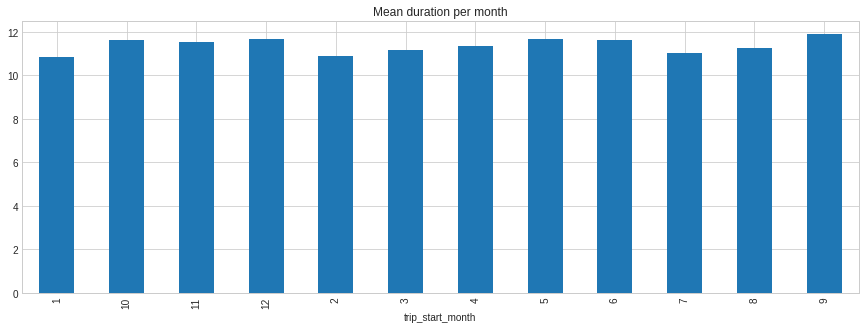

In [31]:

traindf.groupby(['trip_start_month'])['fare'].mean().plot(kind='bar', figsize=(15, 5));
plt.title('Mean duration per month');

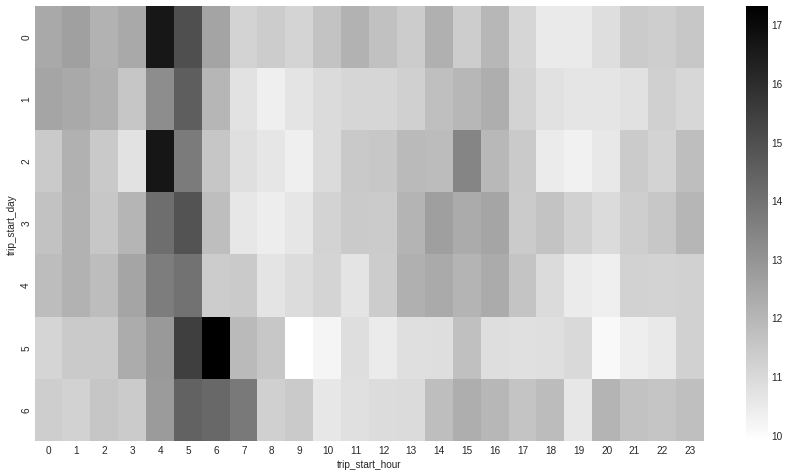

In [32]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

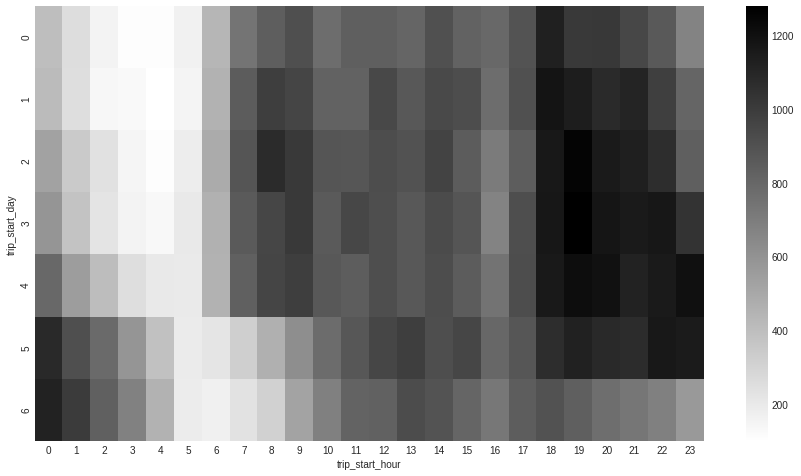

In [33]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

Feature engineering exploration:

In [34]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
traindf.head() 

fare trip_start_month  ... dropoff_longitude  distance
0   4.5                6  ...        -73.841610  0.943584
1  16.9                1  ...        -73.979268  7.969567
2   5.7                8  ...        -73.991242  1.367404
3   7.7                4  ...        -73.991567  2.534047
4   5.3                3  ...        -73.956655  1.946952

[5 rows x 9 columns]

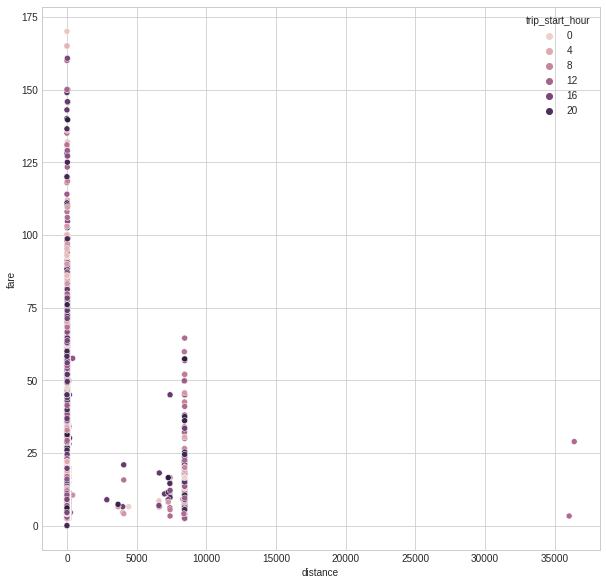

In [35]:
##Fair Vs distance plot( Colored by Trip Start Hour )
plt.figure(figsize=(10, 10))
sns.scatterplot(x=traindf['distance'], y=traindf['fare'], hue=traindf['trip_start_hour'].astype(int))

# Average distance per month distribution

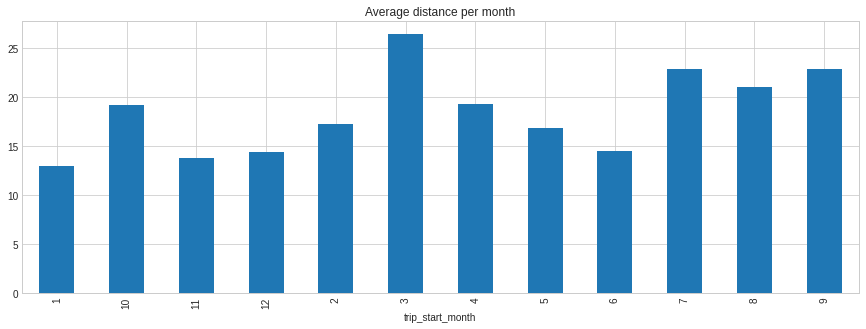

In [36]:

traindf.groupby(['trip_start_month'])['distance'].mean().plot(kind='bar', figsize=(15, 5));
plt.title('Average distance per month');

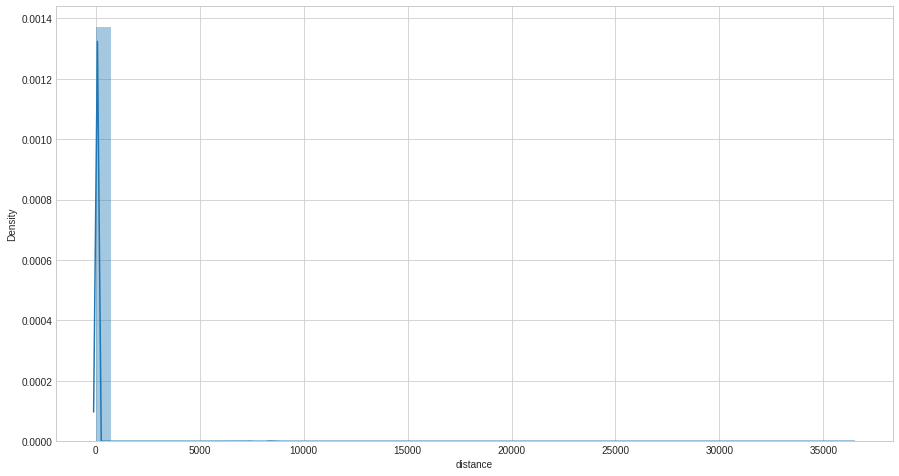

In [37]:
plt.figure(figsize=(15, 8))
sns.distplot(traindf['distance'])

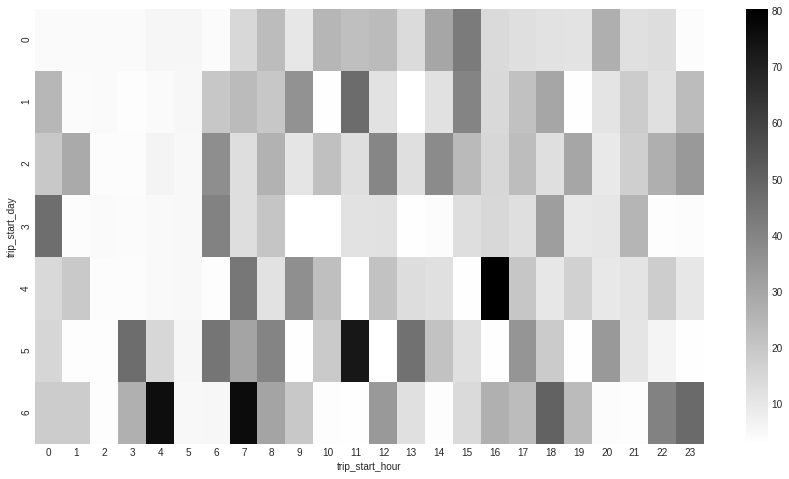

In [38]:
##Average trip distance( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['distance'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [39]:
df


fare trip_start_month  ... dropoff_latitude dropoff_longitude
0        4.50                6  ...        40.712278        -73.841610
1       16.90                1  ...        40.782004        -73.979268
2        5.70                8  ...        40.750562        -73.991242
3        7.70                4  ...        40.758092        -73.991567
4        5.30                3  ...        40.783762        -73.956655
...       ...              ...  ...              ...               ...
149995  49.57               10  ...        40.643617        -73.790216
149996  22.00                9  ...        40.684642        -73.956377
149997   4.50                9  ...        40.763693        -73.970902
149998   7.70                2  ...        40.708452        -73.999600
149999  16.00               12  ...        40.765731        -73.982975

[149984 rows x 8 columns]

#Features Normalization

In [40]:


#Normalizing 

from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df)




In [41]:
df

fare trip_start_month  ... dropoff_latitude dropoff_longitude
0        4.50                6  ...         0.128155         -0.128168
1       16.90                1  ...         0.139571         -0.141403
2        5.70                8  ...         0.134423         -0.142554
3        7.70                4  ...         0.135656         -0.142585
4        5.30                3  ...         0.139859         -0.139229
...       ...              ...  ...              ...               ...
149995  49.57               10  ...         0.116914         -0.123228
149996  22.00                9  ...         0.123631         -0.139202
149997   4.50                9  ...         0.136573         -0.140598
149998   7.70                2  ...         0.127529         -0.143357
149999  16.00               12  ...         0.136907         -0.141759

[149984 rows x 8 columns]

In [42]:
##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

traindf.to_csv("train.csv", index=False, header=False)
evaldf.to_csv("eval.csv", index=False, header=False)
traindf.head()

127469
22515


fare trip_start_month  ... dropoff_latitude dropoff_longitude
0   4.5                6  ...         0.128155         -0.128168
1  16.9                1  ...         0.139571         -0.141403
2   5.7                8  ...         0.134423         -0.142554
3   7.7                4  ...         0.135656         -0.142585
4   5.3                3  ...         0.139859         -0.139229

[5 rows x 8 columns]

In [43]:
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  features['distance'] = ((features['pickup_latitude'] - features['dropoff_latitude'])**2 +  (features['pickup_longitude'] - features['dropoff_longitude'])**2)**0.5

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [44]:
traindf.columns

Index(['fare', 'trip_start_month', 'trip_start_hour', 'trip_start_day',
       'pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude'],
      dtype='object')

In [45]:
###############################
###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare'

# Set default values for each CSV column( Including Y column )
DEFAULTS = [[0.0], ['1'], ['1'],['1'],[0.0],[0.0],[0.0],[0.0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(file_list,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                   column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        
        dataset = dataset.prefetch(buffer_size = batch_size)

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [46]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns

eval_file = "train*.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

(OrderedDict([('trip_start_month', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'11', b'5', b'8', b'1', b'3', b'3', b'6', b'1', b'11', b'6'],
      dtype=object)>), ('trip_start_hour', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'9', b'17', b'14', b'15', b'13', b'19', b'23', b'14', b'8', b'16'],
      dtype=object)>), ('trip_start_day', <tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'2', b'5', b'5', b'2', b'0', b'2', b'2', b'4', b'3', b'1'],
      dtype=object)>), ('pickup_latitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.12860572, 0.13614658, 0.12935172, 0.12549058, 0.13508183,
       0.1371466 , 0.13096786, 0.1397443 , 0.13769732, 0.11788069],
      dtype=float32)>), ('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.14315034, -0.14087157, -0.14127244, -0.139899  , -0.14078075,
       -0.13993517, -0.13983692, -0.1398477 , -0.14073624, -0.12099769],
      dtype=float32)>), ('dropoff_latitude', <tf.Tensor: shape=(10

<DatasetV1Adapter shapes: (OrderedDict([(trip_start_month, (None,)), (trip_start_hour, (None,)), (trip_start_day, (None,)), (pickup_latitude, (None,)), (pickup_longitude, (None,)), (dropoff_latitude, (None,)), (dropoff_longitude, (None,)), (distance, (None,))]), (None,)), types: (OrderedDict([(trip_start_month, tf.string), (trip_start_hour, tf.string), (trip_start_day, tf.string), (pickup_latitude, tf.float32), (pickup_longitude, tf.float32), (dropoff_latitude, tf.float32), (dropoff_longitude, tf.float32), (distance, tf.float32)]), tf.float32)>

In [47]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127469 entries, 0 to 149999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare               127469 non-null  float64
 1   trip_start_month   127469 non-null  object 
 2   trip_start_hour    127469 non-null  object 
 3   trip_start_day     127469 non-null  object 
 4   pickup_latitude    127469 non-null  float64
 5   pickup_longitude   127469 non-null  float64
 6   dropoff_latitude   127469 non-null  float64
 7   dropoff_longitude  127469 non-null  float64
dtypes: float64(5), object(3)
memory usage: 8.8+ MB


In [48]:
# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
   # k_miles = tf.keras.Input(name='trip_miles', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 
                        'dropoff_longitude': k_droplon,
                       # 'trip_miles' : k_miles, 
                        'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'trip_start_day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_day')>,
  'trip_start_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_hour')>,
  'trip_start_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_month')>}}

# Parameters Tuning

In [49]:
#Create model # ajgruti changed beta 1 0.98 and decay : 0.02
params_default = {
    'lr' : 0.002,
    'beta_1' : 0.97,
    'beta_2' : 0.997,
    'epsilon' : 1e-08,
    'decay' : 0.015,
    'hidden_layers' : 1
}

##Feature Engineering
# def featengg_funcs(inp):
#     #Add all calculations, pass out as concatenate
#     vpatd_squared = inp[1] * inp[1]
#     vpatd_neg = -1 * inp[1]

#     return keras.layers.concatenate([vpatd_squared, vpatd_neg], axis = 1)

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat,
                    int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    cat_month, cat_cross_day_hour, cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [50]:

def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00002, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
  )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pickup_latitude (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
pickup_longitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_latitude (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None, 1)]          0                                            
______________________________________________________________________________________________

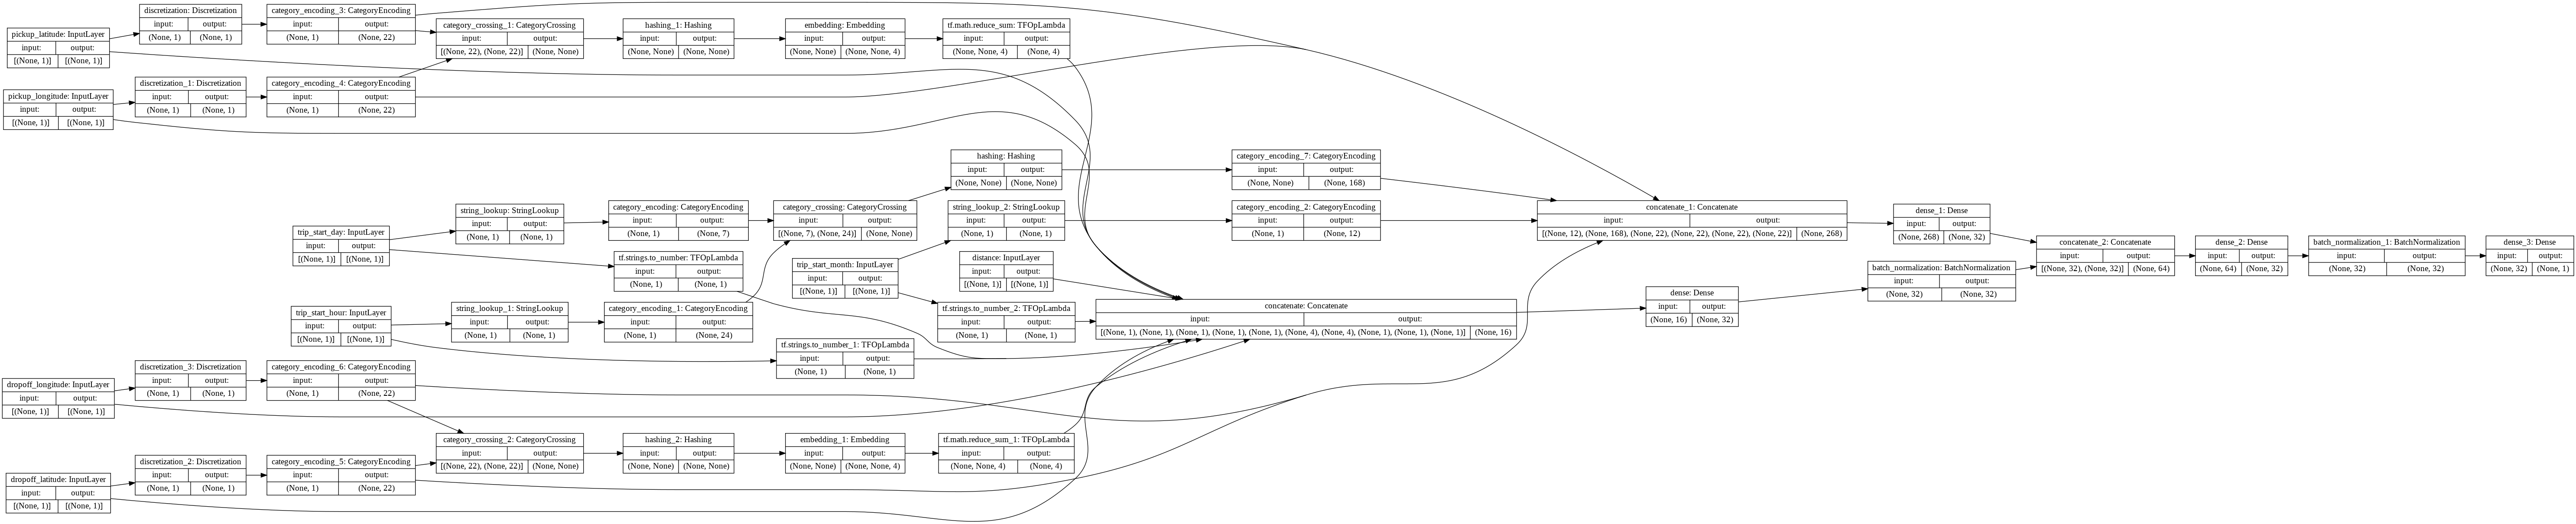

In [51]:

train_dataset = make_input_fn(filename = 'train*.csv',
                    mode = tf.estimator.ModeKeys.TRAIN,
                    # vnum_epochs = epochs,
                    batch_size = 256)()

validation_dataset = make_input_fn(filename = 'eval*.csv',
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 256)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [52]:
# !rm -rf "./logs"
# %tensorboard --logdir "./logs"

#changed from 50 to 70 to increase the number of iterations for the dataset
keras_train_and_evaluate(m_, train_dataset, validation_dataset, 65)

Epoch 1/65
100/100 [==============================] - 53s 489ms/step - loss: 186.2270 - rmse: 13.6301 - val_loss: 114.0162 - val_rmse: 10.6778
Epoch 2/65
100/100 [==============================] - 46s 466ms/step - loss: 126.5574 - rmse: 11.2470 - val_loss: 504.8211 - val_rmse: 22.4682
Epoch 3/65
100/100 [==============================] - 47s 469ms/step - loss: 116.3421 - rmse: 10.7687 - val_loss: 837.8655 - val_rmse: 28.9459
Epoch 4/65
100/100 [==============================] - 46s 463ms/step - loss: 98.2734 - rmse: 9.9120 - val_loss: 252.7272 - val_rmse: 15.8973
Epoch 5/65
100/100 [==============================] - 47s 468ms/step - loss: 100.0630 - rmse: 10.0004 - val_loss: 145.5500 - val_rmse: 12.0643
Epoch 6/65
100/100 [==============================] - 47s 473ms/step - loss: 97.9481 - rmse: 9.8947 - val_loss: 193.4173 - val_rmse: 13.9073

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 7/65
100/100 [==============================] - 47s 468ms/s

In [53]:
# ## Prediction directly using model's instance
# ## BUT HERE ALL FEATURES HAVE TO BE PASSED, EVEN THE Calculated ones
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'trip_start_day': [["1"]],
                         'trip_start_hour': [["5"]],
                         'trip_start_month': [["6"]],
                   #       'trip_miles': [[0.04196861]],
                         'distance':[[0.04196861]]})

m_.predict(data)

array([[13993.692]], dtype=float32)

In [54]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'trip_start_day': trip_start_day,
        'trip_start_hour': trip_start_hour,
        'trip_start_month': trip_start_month,
        'distance': distance
    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                        trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                        trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 

# tf.saved_model.save(
#     m_,
#     "./exported_model/" + version,
#     signatures={'serving_default': serving}
# ) 

INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [55]:
# !zip -r /content/model.zip /content/exported_model/1
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
/content/exported_model/1/
/content/exported_model/1/assets/
/content/exported_model/1/saved_model.pb
/content/exported_model/1/variables/
/content/exported_model/1/variables/variables.data-00000-of-00001
/content/exported_model/1/variables/variables.index


In [ ]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

In [ ]:
###Install TF Model server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

In [59]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

Starting job # 0 in a separate thread.


In [ ]:
!tail server.log

In [ ]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': [41.920452],
                         'dropoff_longitude': [-87.679955],
                         'pickup_latitude': [41.952823],
                         'pickup_longitude': [-87.653244],
                         'trip_start_day': ["1"],
                         'trip_start_hour': ["5"],
                         'trip_start_month': ["6"]}]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text